In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
import warnings; warnings.filterwarnings('ignore')
import tensorflow as tf

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 4)

## Load Datasets

In [4]:
iris_datasets = load_iris()
X_iris, y_iris = iris_datasets.data[:-1, :], iris_datasets.target[:-1]
y_iris = pd.get_dummies(y_iris).values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, test_size=0.33, random_state=90)

## Set Placeholders

In [6]:
num_features = X_train.shape[1] # in the iris dataset, this number is 4
num_labels = y_train.shape[1] # and this number is 3

In [7]:
X = tf.placeholder(tf.float32, [None, num_features]) # iris has 4 features, so X is a tensor to hold our data
y = tf.placeholder(tf.float32, [None, num_labels]) # y is a tensor to hold matrix for 3 classes

## Set Variable

In [8]:
# randomly sample from a normal distribution with standard deviation .01
weights = tf.Variable(tf.random_normal([num_features, num_labels], mean=0, stddev=0.01, name='weights'))
bias = tf.Variable(tf.random_normal([1, num_labels], mean=0, stddev=0.01, name='bias'))

## Set Operation

In [9]:
# three-component breakdown of the Logistic Regression equation
OP_apply_weights = tf.matmul(X, weights, name='apply_weights')
OP_add_bias = tf.add(OP_apply_weights, bias, name='add_bias')
OP_activation = tf.nn.sigmoid(OP_add_bias, name='activation')

## Set Loss Function

In [10]:
OP_loss = tf.nn.l2_loss(OP_activation - y, name='squared_error_loss')

## Set Optimizer

In [11]:
# defining learning rate iteration with decay
learning_rate = tf.train.exponential_decay(learning_rate=8e-4, global_step=1, 
                                           decay_steps=X_train.shape[0], decay_rate=0.95, staircase=True)

In [12]:
# defining Gradient Descent
OP_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(OP_loss)

## Train The Graph

In [13]:
init = tf.global_variables_initializer()

In [14]:
with tf.Session() as sess:
    sess.run(init) # initialize the variables before executing a graph
    
    # operation for tracking our model
    OP_correct_prediction = tf.equal(tf.argmax(OP_activation, 1), tf.argmax(y, 1))

    OP_accuracy = tf.reduce_mean(tf.cast(OP_correct_prediction, 'float'))

    OP_activation_summary = tf.summary.histogram('output', OP_activation)

    OP_accuracy_summary = tf.summary.scalar('accuracy', OP_accuracy)

    OP_loss_summary = tf.summary.scalar('loss', OP_loss)
    
    weight_summary = tf.summary.histogram('weights', weights.eval(session=sess))
    bias_summary = tf.summary.histogram('biases', bias.eval(session=sess))
    
    all_summary = tf.summary.merge([OP_activation_summary, OP_accuracy_summary, OP_loss_summary, weight_summary, bias_summary])
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    
    # initialize reporting variables
    loss = 0
    diff = 1
    epoch_values = []
    accuracy_values = []
    loss_values = []
    num_epochs = 400
    
    for i_epoch in range(1, num_epochs+1):
        
        if i_epoch > 1 and diff < .0001:
            print(f'Change in loss {diff}, convergence.')
            break
        else:
            
            # run training step
            step = sess.run(OP_optimizer, feed_dict={X: X_train, y: y_train})
                        
            # add epoch to epoch values
            epoch_values.append(i_epoch)

            # generate accuracy stats on test data
            train_accuracy, new_loss = sess.run([OP_accuracy, OP_loss], feed_dict={X: X_train, y: y_train})

            # add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)

            # add cost to live graphing variable
            loss_values.append(new_loss)

            # re-assign values for variables
            diff = abs(new_loss - loss)
            loss = new_loss
            
            # report occasional stats
            if i_epoch % 10 == 0:    
                # generate print statements
                print(f'Epoch {i_epoch}, Training Accuracy: {train_accuracy:.6f}, Loss: {new_loss:.6f}, Loss Diff: {diff:.6f}')
                
    # check how well do the model perform held-out test data
    final_accuracy = sess.run(OP_accuracy, feed_dict={X: X_test, y: y_test})
    print(f'Final accuracy on test set: {final_accuracy:.6f}')

Epoch 10, Training Accuracy: 0.535354, Loss: 30.197577, Loss Diff: 0.232487
Epoch 20, Training Accuracy: 0.737374, Loss: 28.109291, Loss Diff: 0.193136
Epoch 30, Training Accuracy: 0.949495, Loss: 26.359640, Loss Diff: 0.160492
Epoch 40, Training Accuracy: 0.969697, Loss: 24.916460, Loss Diff: 0.131819
Epoch 50, Training Accuracy: 0.959596, Loss: 23.732325, Loss Diff: 0.108206
Epoch 60, Training Accuracy: 0.929293, Loss: 22.757540, Loss Diff: 0.089359
Epoch 70, Training Accuracy: 0.919192, Loss: 21.948711, Loss Diff: 0.074484
Epoch 80, Training Accuracy: 0.919192, Loss: 21.270714, Loss Diff: 0.062750
Epoch 90, Training Accuracy: 0.919192, Loss: 20.696091, Loss Diff: 0.053455
Epoch 100, Training Accuracy: 0.929293, Loss: 20.203667, Loss Diff: 0.046040
Epoch 110, Training Accuracy: 0.929293, Loss: 19.777172, Loss Diff: 0.040064
Epoch 120, Training Accuracy: 0.929293, Loss: 19.404036, Loss Diff: 0.035210
Epoch 130, Training Accuracy: 0.929293, Loss: 19.074512, Loss Diff: 0.031223
Epoch 14

## Plot Loss

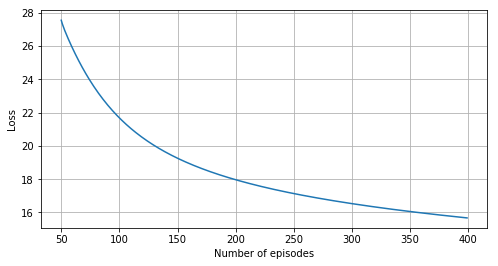

In [15]:
plt.plot([np.mean(loss_values[i-50:i]) for i in range(len(loss_values))])
plt.xlabel('Number of episodes')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

---